# Deep Learning Final Project: Multimodal Sentiment Analysis

Team Members:
- Mohammadreza Estarki  
ID: 400209184
- Sajad Hosseini  
ID: 400301997
- Kasra Kamali  
ID: 400201648

# Phase Two

In [ ]:
# Upgrade gdown to work properly.
!pip install --upgrade --no-cache-dir gdown
# Install CatBoost.
!pip install catboost
# Install PyCM for confusion matrix and model evaluation.
!pip install pycm
# Install Hugging Face's transformes. 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.7/595.7 KB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 M

In [ ]:
import os
import random
import re
import string
import zipfile
from collections import Counter
from itertools import groupby, product

import gdown
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pycm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchvision.models as models
import torchvision.transforms as T
from catboost import CatBoostClassifier
from hyperopt import fmin, hp, tpe
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import GloVe
from torchvision.io import read_image
from torchvision.models import ResNet50_Weights
from torchvision.transforms import (ColorJitter, GaussianBlur,
                                    RandomHorizontalFlip, RandomRotation,
                                    Resize, ToPILImage, ToTensor)
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer
from wordcloud import STOPWORDS, WordCloud
from xgboost import XGBClassifier

First, we need to download the Multimodal Sentiment Chat Translation Dataset (MSCTD).

In [ ]:
# Download the image dataset.
# train data
# original link
!gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
# alternative link
if not(os.path.isfile('./train_ende.zip')):
    print("Using the alternative link...")
    !gdown 1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn


# dev data
# original link
!gdown 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
# alternative link
if not(os.path.isfile('./dev.zip')):
    print("Using the alternative link...")
    !gdown 1-4UxUq_KJKyebCM5ngG_F_COSrpO3fEM


# test data
# original link
!gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
# alternative link
if not(os.path.isfile('./test.zip')):
    print("Using the alternative link...")
    !gdown 1--0w9CvsR6aUYmj1AK4K8Yjt9UgdckeZ

Downloading...
From: https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
To: /content/train_ende.zip
100% 2.90G/2.90G [00:41<00:00, 70.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
To: /content/dev.zip
100% 638M/638M [00:10<00:00, 60.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
To: /content/test.zip
100% 641M/641M [00:10<00:00, 62.5MB/s]


In [ ]:
# Downlaod text files from github.
!git clone https://github.com/XL2248/MSCTD

# Move relevant files to ./data
!mkdir ./data
!mv /content/MSCTD/MSCTD_data/ende /content/data/text

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
# Unzip the train images.
zip_ref = zipfile.ZipFile("./train_ende.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the dev images.
zip_ref = zipfile.ZipFile("./dev.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the test images.
zip_ref = zipfile.ZipFile("./test.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

In [ ]:
# Rename train_ende directory to train.
!mv ./data/train_ende ./data/train

# Remove redundant files.
!rm -r MSCTD
!rm ./data/text/german*.txt
!rm train_ende.zip
!rm dev.zip
!rm test.zip

In [ ]:
# Defining the custom dataloader class.
class MSCTD(torch.utils.data.Dataset):
    def __init__(self, data_path, partition, transform=None, target_transform=None, get_mode = 'utterance', shuffle=False, random_seed=None):
        self.data_path = data_path
        self.partition = partition
        self.imgs_path = os.path.join(data_path, partition)
        self.utterance_path = os.path.join(data_path, 'text', 'english_'+partition+'.txt')
        self.sentiment_path = os.path.join(data_path, 'text', 'sentiment_'+partition+'.txt')
        self.dialogue_path = os.path.join(data_path, 'text', 'image_index_'+partition+'.txt')

        self.transform = transform
        self.target_transform = target_transform
        self.get_mode = get_mode
        self.shuffle = shuffle

        # Read the utterance indices that form a dialogue for the given partition.
        with open(self.dialogue_path) as f:
            self.dialogue = [np.array(line[1:-2].split(', '), dtype=int) for line in f]
            f.close()

        # Read the English utterances for the given partition.
        with open(self.utterance_path) as f:
            self.utterance = [line.rstrip('\n') for line in f]
        f.close()

        # Read the sentiment labels for the given partition.
        self.sentiment_labels = np.loadtxt(self.sentiment_path, dtype=int)

        # Generate shuffling indices.
        rng = np.random.default_rng(seed=random_seed)
        
        self.shfl_idx_dlg = np.arange(len(self.dialogue))
        rng.shuffle(self.shfl_idx_dlg)

        self.shfl_idx_utt = np.arange(len(self.utterance))
        rng.shuffle(self.shfl_idx_utt)

    def __len__(self):
        if self.get_mode == 'utterance':
            return len(self.utterance)
        elif self.get_mode == 'dialogue':
            return len(self.dialogue)
        else:
            return None

    def __getitem__(self, idx):
        if self.get_mode == 'utterance':
            if self.shuffle:
                idx = self.shfl_idx_utt[idx]

            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]
            sentiment = self.sentiment_labels[idx]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                sentiment = self.target_transform(sentiment)

            return image, utterance, sentiment

        elif self.get_mode == 'dialogue':
            if self.shuffle:
                idx = self.shfl_idx_dlg[idx]

            images = []
            utterances = []
            sentiments = []

            for i in self.dialogue[idx]:
                img_path = os.path.join(self.imgs_path, str(i)+'.jpg')
                images.append(read_image(img_path))
                utterances.append(self.utterance[i])
                sentiments.append(self.sentiment_labels[i])

            return images, utterances, sentiments

        else:
            return None

In [ ]:
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='utterance')
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='utterance')
test_data = MSCTD(data_path='./data', partition='test', get_mode='utterance')

## Part 1: Creating Representation Vectors

### Section 1: TF-IDF Vectors

In this section, we use the TF-IDF vectors to predict the sentiment label for each utterance. The tf-idf, which stands for term frequency-inverse document frequency, creates a vector representation for each document and we can use that representation to predict the related sentiment.

First, we need to clean and preprocess the documents to achieve better tf-idf representation vectors. 

In [ ]:
# Download required packages for nltk library.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Define a function for text preprocessing.
def preprocess_text(corpus):
    stop_words = stopwords.words('english')
    table = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()

    corpus_processed = []
    for utt in corpus:
        # Tokenize each sentence.
        tokens = word_tokenize(utt)
        # Convert words to lower case.
        tokens = [w.lower() for w in tokens]
        # Remove stop words.
        tokens = [w for w in tokens if w not in stop_words]
        # Remove punctuations.
        tokens = [w.translate(table) for w in tokens]
        # Remove non alphabetic words and words that are shorter than 3 characters.
        tokens = [w for w in tokens if w.isalpha() and len(w)>2]
        # Lemmatize words.
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
        # Remove 1 character words after lemmatizing.
        # tokens = [w for w in tokens if len(w)>1]
        # Join tokens to form a sentence.
        utt_processed = ' '.join(tokens)
        # If utterance is null, append oov.
        if utt_processed == '':
            corpus_processed.append('oov')
        else:
            corpus_processed.append(utt_processed)
    
    return corpus_processed

In [ ]:
# Preprocess the train, dev and test corpuses.
train_corpus = preprocess_text(train_data.utterance)
dev_corpus = preprocess_text(dev_data.utterance)
test_corpus = preprocess_text(test_data.utterance)

In [ ]:
# Create a tf-idf vectorizer
vectorizer = TfidfVectorizer()

# Compute tf-idf matrices.
X_train = vectorizer.fit_transform(train_corpus)
y_train = train_data.sentiment_labels

X_dev = vectorizer.transform(dev_corpus)
y_dev = dev_data.sentiment_labels

X_test = vectorizer.transform(test_corpus)
y_test = test_data.sentiment_labels

Now that we have the tf-idf representations, we use two different methods and try to predict the sentiment labels.

#### XGBoost

In [ ]:
# Define an XGBClassifier and fit it on the train data.
clf = XGBClassifier(max_depth=4)
clf.fit(X_train, y_train)

XGBClassifier(max_depth=4, objective='multi:softprob')

In [ ]:
# Predict the sentiments.
pred_train = clf.predict(X_train)
pred_dev = clf.predict(X_dev)
pred_test = clf.predict(X_test)

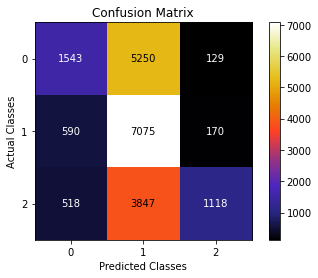


Train Accuracy: 0.4810276679841897
Train F1 Score (Macro): 0.4119447925121353


In [ ]:
# Train data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_train, predict_vector=pred_train.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTrain Accuracy: {accuracy_score(y_train, pred_train)}")
print(f"Train F1 Score (Macro): {f1_score(y_train, pred_train, average='macro')}")

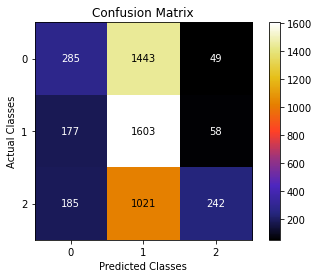


Dev Accuracy: 0.4206991902034367
Dev F1 Score (Macro): 0.3491386735416066


In [ ]:
# Dev data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_dev, predict_vector=pred_dev.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nDev Accuracy: {accuracy_score(y_dev, pred_dev)}")
print(f"Dev F1 Score (Macro): {f1_score(y_dev, pred_dev, average='macro')}")

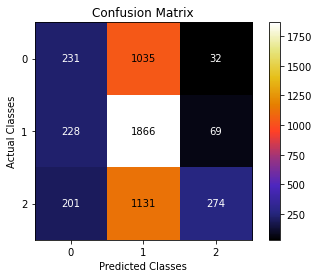


Test Accuracy: 0.4679297414643773
Test F1 Score (Macro): 0.37166810978657683


In [ ]:
# Test data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_test, predict_vector=pred_test.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTest Accuracy: {accuracy_score(y_test, pred_test)}")
print(f"Test F1 Score (Macro): {f1_score(y_test, pred_test, average='macro')}")

#### CatBoost

Now, we use the CatBoost classifier and use the hyperopt library to find the best hyperparameters.

In [ ]:
# Define the seacrh space.
search_space = {'iterations': hp.quniform('iterations', 50, 80, 5),
                'depth': hp.quniform('depth', 3, 7, 1),
                'lr': hp.uniform('lr', 0.1, 0.5)
               }

# Define the optimizer function.
def opt_fn(search_space):
    clf = CatBoostClassifier(iterations=search_space['iterations'],
                             depth=search_space['depth'],
                             learning_rate=search_space['lr'],
                             loss_function='MultiClass',
                            #  od_type='Iter'
                             )    
    
    clf.fit(X_train, y_train, logging_level='Silent')
    predictions = clf.predict(X_dev)

    accuracy = accuracy_score(y_dev, predictions)
    return -accuracy

# Find the best hyperparameters.
best = fmin(fn=opt_fn, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=10)

100%|██████████| 10/10 [01:20<00:00,  8.07s/it, best loss: -0.43393245111593914]


In [ ]:
print('Best Parameters:', best)

Best Parameters: {'depth': 7.0, 'iterations': 75.0, 'lr': 0.4934384153402436}


In [ ]:
# Set best hyperparameters.
itr = 75
dpth = 7
lr = 0.46809459236498313

# Define and train the catboost classifier.
clf = CatBoostClassifier(iterations=itr,
                           depth=dpth,
                           learning_rate=lr,
                           loss_function='MultiClass',
                        #    verbose=False
                        )

clf.fit(X_train, y_train)

0:	learn: 1.0797398	total: 401ms	remaining: 29.7s
1:	learn: 1.0705663	total: 724ms	remaining: 26.4s
2:	learn: 1.0638289	total: 1.09s	remaining: 26.1s
3:	learn: 1.0599019	total: 1.44s	remaining: 25.5s
4:	learn: 1.0561225	total: 1.78s	remaining: 25s
5:	learn: 1.0534329	total: 2.15s	remaining: 24.8s
6:	learn: 1.0503792	total: 2.51s	remaining: 24.4s
7:	learn: 1.0469980	total: 2.86s	remaining: 23.9s
8:	learn: 1.0448577	total: 3.23s	remaining: 23.7s
9:	learn: 1.0433537	total: 3.59s	remaining: 23.3s
10:	learn: 1.0411882	total: 3.93s	remaining: 22.9s
11:	learn: 1.0393342	total: 4.28s	remaining: 22.5s
12:	learn: 1.0372251	total: 4.63s	remaining: 22.1s
13:	learn: 1.0353045	total: 5s	remaining: 21.8s
14:	learn: 1.0336367	total: 5.35s	remaining: 21.4s
15:	learn: 1.0320966	total: 5.69s	remaining: 21s
16:	learn: 1.0304666	total: 6.04s	remaining: 20.6s
17:	learn: 1.0291025	total: 6.39s	remaining: 20.2s
18:	learn: 1.0276562	total: 6.74s	remaining: 19.9s
19:	learn: 1.0264926	total: 7.09s	remaining: 19.

In [ ]:
# Predict the sentiments.
pred_train = clf.predict(X_train)
pred_dev = clf.predict(X_dev)
pred_test = clf.predict(X_test)

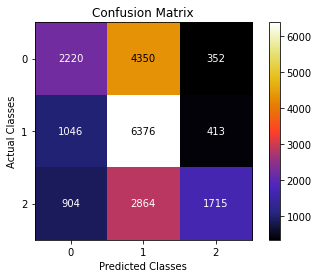


Train Accuracy: 0.5094367588932807
Train F1 Score (Macro): 0.47540773696555605


In [ ]:
# Train data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_train, predict_vector=pred_train.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTrain Accuracy: {accuracy_score(y_train, pred_train)}")
print(f"Train F1 Score (Macro): {f1_score(y_train, pred_train, average='macro')}")

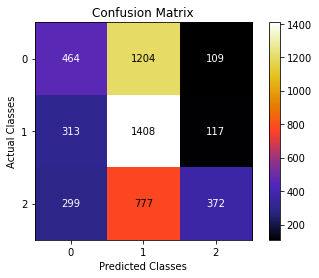


Dev Accuracy: 0.4432154848903812
Dev F1 Score (Macro): 0.4092163864107527


In [ ]:
# Dev data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_dev, predict_vector=pred_dev.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nDev Accuracy: {accuracy_score(y_dev, pred_dev)}")
print(f"Dev F1 Score (Macro): {f1_score(y_dev, pred_dev, average='macro')}")

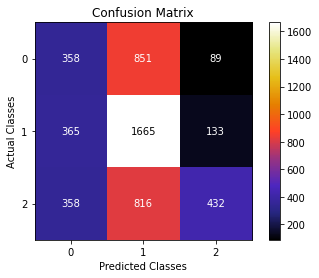


Test Accuracy: 0.48450759818433
Test F1 Score (Macro): 0.4297577124114893


In [ ]:
# Test data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_test, predict_vector=pred_test.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTest Accuracy: {accuracy_score(y_test, pred_test)}")
print(f"Test F1 Score (Macro): {f1_score(y_test, pred_test, average='macro')}")

As can be seen, the CatBoost classifier achieves higher accuracy than the XGBoost classifier.

In [ ]:
# Test Data Statistics
print('***Test Data Statistics***')
print('-'*26)
cm.stat(summary=True)

***Test Data Statistics***
--------------------------
Overall Statistics : 

ACC Macro                                                         0.65634
F1 Macro                                                          0.42976
FPR Macro                                                         0.27667
Kappa                                                             0.17353
Overall ACC                                                       0.48451
PPV Macro                                                         0.49714
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.43819
Zero-one Loss                                                     2612

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.6718        0.57273       0.72449       
AUC(Area under the ROC

### Section 2: Similar Word2Vec Vectors

By using the computed TF-IDF vectors from the previous section, Now we try to find similar word representations to Word2Vec by training an SVM classifier for each word.  

In [ ]:
# Warning: This cell takes about 3 hours to run. The computed embeddings can be downloaded in the following cells.

# Define the word2vec array to store the embeddings.
word2vec = np.zeros((X_train.shape[0]+1, X_train.shape[1]))
tknzr = vectorizer.build_tokenizer()

loop = tqdm(enumerate(vectorizer.get_feature_names_out()), total=len(vectorizer.get_feature_names_out()))
# Find the word2vec embeddings for each word in our corpus.
for i, word in loop:
    embedding = []
    clf = SVC(kernel='linear')
    for doc in train_corpus:
        if word in doc:
            # Find neighboring words.
            neighbors = [x for x in tknzr(doc) if x!=word]
            # Remove duplicate words.
            neighbors = [*set(neighbors)]
            # Find the indices of neighboring words.
            neighbors_idx = [np.argwhere(vectorizer.get_feature_names_out()==x)[0][0] for x in neighbors]
            
            pos_idx = [i]+neighbors_idx
            # Find indices of words with negative label.
            neg_idx = []
            while True:
                id = np.random.default_rng().integers(len(vectorizer.get_feature_names_out()))
                if id not in pos_idx:
                    neg_idx.append(id)
                if len(neg_idx) == len(pos_idx):
                    break

            trainset = np.concatenate([X_train[:, i].toarray() for i in pos_idx+neg_idx], axis=1).T
            labels = np.array([+1]*(len(pos_idx))+[-1]*(len(neg_idx)))
            # Train the SVM.
            clf.fit(trainset, labels)
            # Append SVM weights to the embedding list.
            embedding.append(np.concatenate([clf.coef_.flatten(), clf.intercept_]))
    # Average the embeddings and save the new embedding in an array.
    word2vec[:, i] = sum(embedding)/len(embedding)

  0%|          | 0/8499 [00:00<?, ?it/s]

In [ ]:
# Save the computed embeddings.
np.save('./word2vec.npy', word2vec)

In [ ]:
# Download the word2vec from drive.
!gdown 19n3AG-ff6R2tEeUQVAF8_vUHClhZK6Ln
# Load the word2vec.
word2vec = np.load('./word2vec.npy')

Downloading...
From: https://drive.google.com/uc?id=19n3AG-ff6R2tEeUQVAF8_vUHClhZK6Ln
To: /content/word2vec.npy
100% 1.38G/1.38G [00:13<00:00, 101MB/s]


Since each word has a dimension of 20240 in the computed embeddings, now we use PCA to make the embedding vectors shorter.

In [ ]:
# Use PCA to make the vectors shorter.
n_feat = 100
pca = PCA(n_components=n_feat)
word2vec_50d = pca.fit_transform(word2vec.T)

In [ ]:
# Find the maximum number of words in our documents.
max_length = max([len((word_tokenize(utt))) for utt in train_corpus+dev_corpus])

In [ ]:
# Define a function to create a representation vector for the input utterance given the word embeddings.
def utt2vec(utt, word2vec, mode='concat', max_length=10):
    tokens = word_tokenize(utt)
    token_ids = []
    for w in tokens:
        try:
            idx = np.argwhere(vectorizer.get_feature_names_out()==w)[0][0]
        except:
            idx = np.argwhere(vectorizer.get_feature_names_out()=='oov')[0][0]
        token_ids.append(idx)
    
    # Concatenate or add word embedding vectors.
    if mode=='concat':
        vec = np.concatenate([word2vec[:, i] for i in token_ids[:max_length]])
        vec = np.pad(vec, (0, max_length*len(word2vec)-len(vec)))
    else:
        vec = sum([word2vec[:, i] for i in token_ids])

    return vec

In [ ]:
# Find the utterance vector representations for the train corpus.
X_w2v_train = np.zeros((len(train_corpus), max_length*n_feat))

for i, utt in tqdm(enumerate(train_corpus), total=len(train_corpus)):
    X_w2v_train[i, :] = utt2vec(utt, word2vec_50d.T, mode='concat')

  0%|          | 0/20240 [00:00<?, ?it/s]

In [ ]:
# Find the utterance vector representations for the dev corpus.
X_w2v_dev = np.zeros((len(dev_corpus), max_length*n_feat))

for i, utt in tqdm(enumerate(dev_corpus), total=len(dev_corpus)):
    X_w2v_dev[i, :] = utt2vec(utt, word2vec_50d.T, mode='concat')

  0%|          | 0/5063 [00:00<?, ?it/s]

In [ ]:
# Find the utterance vector representations for the test corpus.
X_w2v_test = np.zeros((len(test_corpus), max_length*n_feat))

for i, utt in tqdm(enumerate(test_corpus), total=len(test_corpus)):
    X_w2v_test[i, :] = utt2vec(utt, word2vec_50d.T, mode='concat')

  0%|          | 0/5067 [00:00<?, ?it/s]

In [ ]:
# Define the seacrh space.
search_space = {'iterations': hp.quniform('iterations', 50, 80, 5),
                'depth': hp.quniform('depth', 3, 7, 1),
                'lr': hp.uniform('lr', 0.1, 0.5)
               }

# Define the optimizer function.
def opt_fn(search_space):
    clf = CatBoostClassifier(iterations=search_space['iterations'],
                             depth=search_space['depth'],
                             learning_rate=search_space['lr'],
                             loss_function='MultiClass',
                            #  od_type='Iter'
                             )    
    
    clf.fit(X_w2v_train, y_train, logging_level='Silent')
    predictions = clf.predict(X_w2v_dev)

    accuracy = accuracy_score(y_dev, predictions)
    return -accuracy

# Find the best hyperparameters.
best = fmin(fn=opt_fn, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=10)

100%|██████████| 10/10 [06:43<00:00, 40.31s/it, best loss: -0.44760213143872113]


In [ ]:
print('Best Parameters:', best)

Best Parameters: {'depth': 6.0, 'iterations': 65.0, 'lr': 0.30872407996829626}


In [ ]:
# Set best hyperparameters
itr = 65
dpth = 6
lr = 0.30872407996829626

# Define and train the catboost classifier.
clf = CatBoostClassifier(iterations=itr,
                           depth=dpth,
                           learning_rate=lr,
                           loss_function='MultiClass',
                        #    verbose=False
                        )

clf.fit(X_w2v_train, y_train)

0:	learn: 1.0865053	total: 1.44s	remaining: 1m 31s
1:	learn: 1.0798935	total: 2.11s	remaining: 1m 6s
2:	learn: 1.0740400	total: 2.82s	remaining: 58.3s
3:	learn: 1.0713368	total: 3.47s	remaining: 52.9s
4:	learn: 1.0668308	total: 4.12s	remaining: 49.4s
5:	learn: 1.0605491	total: 4.84s	remaining: 47.6s
6:	learn: 1.0571003	total: 5.51s	remaining: 45.7s
7:	learn: 1.0546698	total: 6.21s	remaining: 44.2s
8:	learn: 1.0533714	total: 6.85s	remaining: 42.6s
9:	learn: 1.0470099	total: 7.54s	remaining: 41.5s
10:	learn: 1.0453358	total: 8.17s	remaining: 40.1s
11:	learn: 1.0439295	total: 8.89s	remaining: 39.3s
12:	learn: 1.0393312	total: 10.1s	remaining: 40.5s
13:	learn: 1.0364339	total: 11.4s	remaining: 41.5s
14:	learn: 1.0355597	total: 12.6s	remaining: 42s
15:	learn: 1.0349426	total: 13.4s	remaining: 41.1s
16:	learn: 1.0334325	total: 14.2s	remaining: 40.1s
17:	learn: 1.0317436	total: 15.4s	remaining: 40.1s
18:	learn: 1.0301833	total: 16.5s	remaining: 40s
19:	learn: 1.0293058	total: 17.7s	remaining:

In [ ]:
# Predict the sentiments.
pred_train = clf.predict(X_w2v_train)
pred_dev = clf.predict(X_w2v_dev)
pred_test = clf.predict(X_w2v_test)

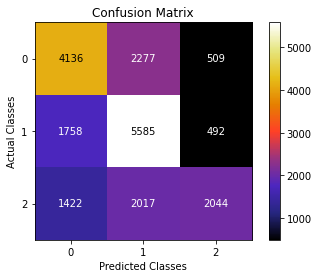


Train Accuracy: 0.5812747035573123
Train F1 Score (Macro): 0.5636390875958668


In [ ]:
# Train data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_train, predict_vector=pred_train.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTrain Accuracy: {accuracy_score(y_train, pred_train)}")
print(f"Train F1 Score (Macro): {f1_score(y_train, pred_train, average='macro')}")

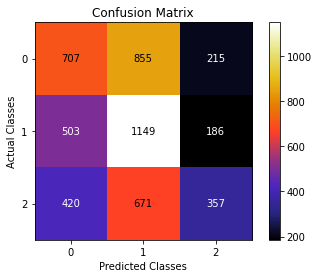


Dev Accuracy: 0.4370926328263875
Dev F1 Score (Macro): 0.4159620929156447


In [ ]:
# Dev data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_dev, predict_vector=pred_dev.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nDev Accuracy: {accuracy_score(y_dev, pred_dev)}")
print(f"Dev F1 Score (Macro): {f1_score(y_dev, pred_dev, average='macro')}")

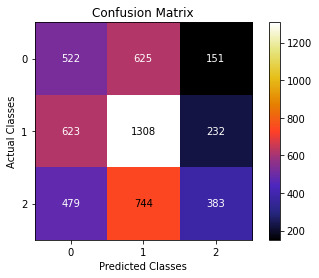


Test Accuracy: 0.436747582395895
Test F1 Score (Macro): 0.4069065427347809


In [ ]:
# Test data evaluation.
cm = pycm.ConfusionMatrix(actual_vector=y_test, predict_vector=pred_test.flatten())
cm.plot(cmap=plt.cm.CMRmap, number_label=True, plot_lib="matplotlib")
plt.show()
print(f"\nTest Accuracy: {accuracy_score(y_test, pred_test)}")
print(f"Test F1 Score (Macro): {f1_score(y_test, pred_test, average='macro')}")

By comparing the results to the previous section, we can see that although the train accuracy increased, the dev and test accuracies decreased.

In [ ]:
# Test Data Statistics
print('***Test Data Statistics***')
print('-'*26)
cm.stat(summary=True)

***Test Data Statistics***
--------------------------
Overall Statistics : 

ACC Macro                                                         0.6245
F1 Macro                                                          0.40691
FPR Macro                                                         0.29149
Kappa                                                             0.126
Overall ACC                                                       0.43675
PPV Macro                                                         0.43668
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.41512
Zero-one Loss                                                     2854

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.62937       0.56108       0.68305       
AUC(Area under the ROC cu

## Part 2: Embedding with GloVe

### Section 1: Prepare Data for Glove Tokenizer

In [ ]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


First, convert all train, dev and test datasets to separate DataFrames with utterence and sentiment as columns. Then use word cloud to demonstrate most frequent words in each sentiment label of train data.

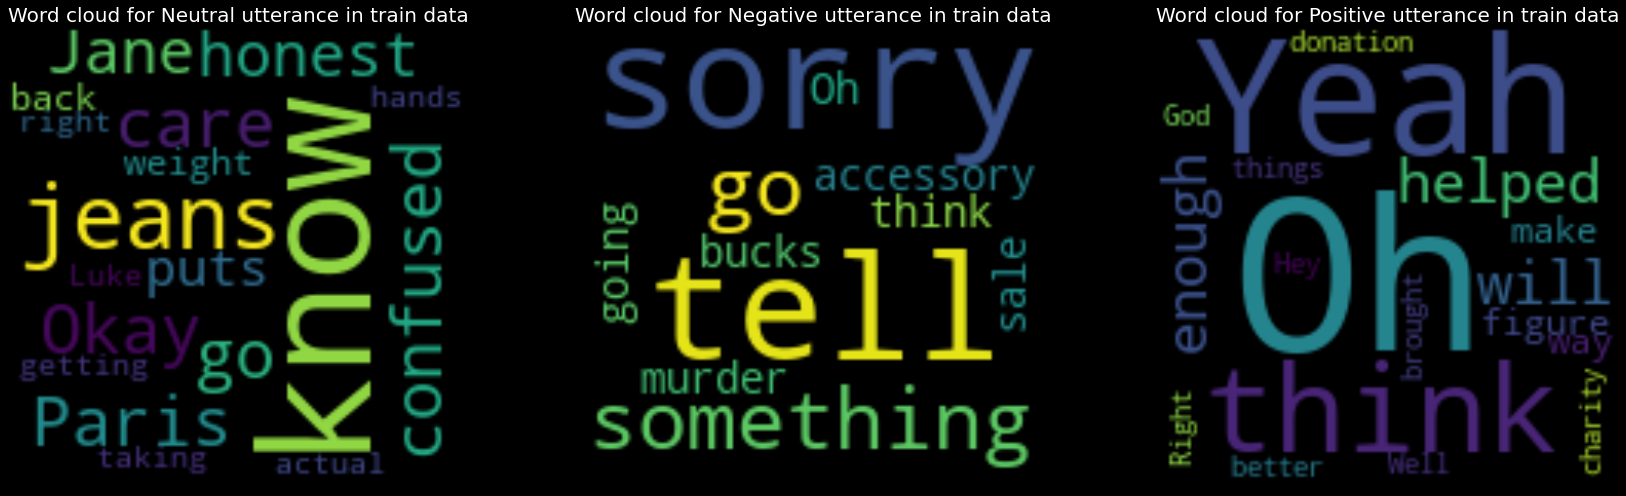

In [ ]:
# prepare train data 
tr_sentiments = pd.DataFrame(train_data.sentiment_labels, columns=["sentiments"])
tr_utterance = pd.DataFrame(train_data.utterance, columns=["utterance"])
tr_df = pd.concat([tr_utterance,tr_sentiments],axis=1,join='inner')

# prepare dev data
dev_sentiments = pd.DataFrame(dev_data.sentiment_labels, columns=["sentiments"])
dev_utterance =  pd.DataFrame(dev_data.utterance, columns=["utterance"])
dev_df = pd.concat([dev_utterance,dev_sentiments],axis=1,join='inner')

# prepare test data
te_sentiments = pd.DataFrame(test_data.sentiment_labels, columns=["sentiments"])
te_utterance = pd.DataFrame(test_data.utterance, columns=["utterance"])
te_df = pd.concat([te_utterance,te_sentiments],axis=1,join='inner')

# find utterances in train data that have different labels
Neutral_utterance = tr_df['utterance'].loc[tr_df['sentiments']==0].values
Negative_utterance = tr_df['utterance'].loc[tr_df['sentiments']==1].values
Positive_utterance = tr_df['utterance'].loc[tr_df['sentiments']==2].values
# make a word cloud of them
wordcloud_Neutral= WordCloud(width = 150,height = 150, background_color = 'black', stopwords = STOPWORDS).generate(str(Neutral_utterance))
wordcloud_Negative= WordCloud(width = 150,height = 150, background_color = 'black', stopwords = STOPWORDS).generate(str(Negative_utterance))
wordcloud_Positive= WordCloud(width = 150,height = 150, background_color = 'black', stopwords = STOPWORDS).generate(str(Positive_utterance))
# word cloud plot
fig, axes = plt.subplots(1,3,figsize=(24, 7), facecolor = 'k', edgecolor = 'k')
fg_color = 'white'
bg_color = 'black'
axes[0].imshow(wordcloud_Neutral, interpolation = 'bilinear')
axes[1].imshow(wordcloud_Negative, interpolation = 'bilinear')
axes[2].imshow(wordcloud_Positive, interpolation = 'bilinear')
axes[0].set_title("Word cloud for Neutral utterance in train data",fontsize=20, color=fg_color)
axes[1].set_title("Word cloud for Negative utterance in train data",fontsize=20, color=fg_color)
axes[2].set_title("Word cloud for Positive utterance in train data",fontsize=20, color=fg_color)
for i in range(3):
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Clean all utterances with re library. Define a text_cleaner function to remove number and punctuation. Then convert characters to lower case. Also substitute multiple whitespace with single whitespace.

In [ ]:
# Define a text_cleaner function to remove number and punctuation. Then convert characters to lower case.
def text_cleaner(data):
  clean_utterence = []
  for idx, line in enumerate(data):
      # remove numbers
      text_nonum = re.sub(r'\d+', '', line)
      # remove punctuations
      text_nopunct = re.sub("[^-9A-Za-z ]", "" , text_nonum) 
      # convert characters to lower case
      text_lower = text_nopunct.lower()
      # substitute multiple whitespace with single whitespace
      text_no_doublespace = re.sub('\s+', ' ', text_lower).strip()
      # append all words to a clean data
      clean_utterence.append(text_no_doublespace)
  return clean_utterence

Apply text_cleaner function to train, dev and test data. Add a new column to each dataframe as clean_utterence.

In [ ]:
# Train utterence
tr_df["Clean_utterance"]= text_cleaner(tr_df["utterance"])
# dev utterence
dev_df["Clean_utterance"]= text_cleaner(dev_df["utterance"])
# test utterence
te_df["Clean_utterance"]= text_cleaner(te_df["utterance"])
# sample of clean train utterences
tr_df.head()

,utterance,sentiments,Clean_utterance
0,Okay. I'm confused.,0,okay im confused
1,"You don't care if I go to Paris with Jane,",0,you dont care if i go to paris with jane
2,"I'm sorry. I have to tell you something,",1,im sorry i have to tell you something
3,I have to go.,1,i have to go
4,I'm an accessory to murder.,1,im an accessory to murder


### Section 2: Word Embedding with GloVe-6B-50d and Torchtext:

In this section, First we have loaded a simple tokenizer available from `torchtext.data` module. 

Then we have loaded GloVe-6B-5d embeddings that available from `torchtext.data` module. 

At the end, we have loaded our dataset And create torch DataLoaders with collate_fn for train and dev data, which tokenize input utterences of with batch size dimensionality and returned a torch tensor.

In [ ]:
# Define tokenizer function, use basic_english tokenizer, which normalize the string first and split by space.
tokenizer = get_tokenizer("basic_english", language='en')

# Load GloVe-6B-50d, which has embedding words to a vector with 50 columns.
GloVe_global_vectors = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:10<00:00, 38099.52it/s]


Define a Tokenizer_Padding_vector_creater function to tokenize each utterence according to the GloVe global vector, Afterwards pad each vector to the desired maximum-utterence-length in order to obtain a batch of them in dataloader. 

In [ ]:
# Batch size, Embedding-dim and maximum-utterence-length:
Batch_size = 128
Embedding_dim = 50
max_utterence_len = 25

# Define a pair-data function to zip Clean_utterance to it's label
def pair_data(data_df):
    Clean_utterance = list(data_df["Clean_utterance"])
    sentiments = list(data_df["sentiments"])
    return zip(Clean_utterance, sentiments)

# Define a Tokenizer_Padding_vector_creater function
def Tokenizer_Padding_vector_creater(Data_pair):
    # Unpair sentiment label from utterence data
    Clean_utterances, sentiments = list(zip(*Data_pair))

    # Tokenize each utterence with defined torch text tokenizer
    tokenize_utterences = []
    for line in Clean_utterances:
        tokenize_utterences.append(tokenizer(line))

    # Pad each tokenized utterence to the desired maximum length
    pad_utterences = []
    for token_vec in tokenize_utterences:
        if len(token_vec) < max_utterence_len:
           padding_num = max_utterence_len-len(token_vec)
           pad_vector = token_vec + [""] * padding_num
        pad_utterences.append(pad_vector)

    # Use GloVe vector to make utterence vector 
    utterences_tensor = torch.zeros(len(Data_pair), max_utterence_len, Embedding_dim)
    for idx, token_vec in enumerate(pad_utterences):
        utterences_tensor[idx] = GloVe_global_vectors.get_vecs_by_tokens(token_vec, lower_case_backup=True)

    return utterences_tensor.reshape(len(Data_pair), -1).float().to(device), torch.tensor(sentiments).type(torch.LongTensor).to(device)

Create train, dev and test dataloader with pytorch dataloader. First pair cleaned utterence with it's sentiment label. Afterwards use to_map_style_dataset function from torchtext.data.function library, which prepare suitable mapping for text dataset. At the end, load data with torch dataloader. When creating data loaders, we have given a function to collate_fn parameter of DataLoader() constructor. This function will be applied to all batches and the return value of this function will be our single dataset.

In [ ]:
# Pair cleaned utterence to it's label for train data
train_pair = pair_data(tr_df)
# Pair cleaned utterence to it's label for dev data
dev_pair = pair_data(dev_df)
# Pair cleaned utterence to it's label for test data
test_pair = pair_data(te_df)

# Use to_map_style_dataset for train data 
train_dataset = to_map_style_dataset(train_pair)

# Use to_map_style_dataset for dev data 
dev_dataset = to_map_style_dataset(dev_pair)

# Use to_map_style_dataset for test data 
test_dataset = to_map_style_dataset(test_pair)

# Load train data with torch Dataloader with collate_fn for tokenize and padding
train_loader = DataLoader(train_dataset, batch_size = Batch_size, collate_fn = Tokenizer_Padding_vector_creater)
# Load train data with torch Dataloader with collate_fn for tokenize and padding
dev_loader = DataLoader(dev_dataset, batch_size = Batch_size, collate_fn = Tokenizer_Padding_vector_creater)
# Load train data with torch Dataloader with collate_fn for tokenize and padding
test_loader = DataLoader(test_dataset, batch_size = Batch_size, collate_fn = Tokenizer_Padding_vector_creater)

### Section 3: Define and Train a MLP Model for Sentiment classification with GloVe Embedding.

In [ ]:
class GloVe_Classification_MLP(nn.Module):
    def __init__(self):
        super(GloVe_Classification_MLP, self).__init__()
        self.linear1 = nn.Linear(50*25,256)
        self.relu1 = nn.ReLU()
        self.Do1 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(256,64)
        self.relu2 = nn.ReLU()
        self.Do2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(64,3)
        self.softmax = nn.Softmax(dim=1)

        # weights initialization with xavier method
        nn.init.xavier_uniform_(self.linear1.weight) 
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight) 
        nn.init.zeros_(self.linear2.bias)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias) 
    
    def forward(self, tokenize_utterence):
        x = self.linear1(tokenize_utterence)
        x = self.relu1(x)
        x = self.Do1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.Do2(x)
        x = self.linear3(x)
        logit = self.softmax(x)
        return logit

# Build model and make to device
GloVe_Classification_MLP_Model = GloVe_Classification_MLP()
GloVe_Classification_MLP_Model.to(device)

# Set all parameters need to be update
for param in GloVe_Classification_MLP_Model.parameters():
    param.requires_grad = True

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size_train = len(dataloader.dataset)
    i = 0
    with tqdm(dataloader, unit="batch") as n_epoch:
        i += 1
        for (cleaned_utterence, sentiment_label) in n_epoch:          
            # Compute batch size
            size_batch = sentiment_label.shape[0]
            # get all parapmeters to device
            cleaned_utterence = cleaned_utterence.to(device)
            sentiment_label = sentiment_label.to(device)

            # Compute logits of model  
            pred = model(cleaned_utterence)
            # Compute loss 
            loss = loss_fn(pred, sentiment_label)
      
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
              loss, current = loss.item(), i * len(size_batch)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size_train:>5d}]")

def test_loop(dataloader, model, loss_fn):
    Test_size = len(dataloader.dataset)
    test_Loss, Test_Correct = 0, 0
    model.eval()
    with torch.no_grad():
        for  (cleaned_utterence, sentiment_label) in dataloader:
            # Compute prediction and loss
            cleaned_utterence = cleaned_utterence.to(device)
            sentiment_label = sentiment_label.to(device)

            pred = model(cleaned_utterence)

            test_Loss += loss_fn(pred, sentiment_label).item()
            Test_Correct += (pred.argmax(1) == sentiment_label).type(torch.float).sum().item()

    test_Loss /= Test_size
    Test_Correct /= Test_size
    print(f" Test Error : Accuracy = {(100*Test_Correct):>0.1f}%, Avg loss = {test_Loss:>8f} \n")

In [ ]:
# Set Hyperparameters of training
Epochs = 20
lr = 5e-5
# Use Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, GloVe_Classification_MLP_Model.parameters()), lr=lr)
# Trining
for epoch in range(Epochs):
    print(f" Epoch {epoch+1} -------------------------------")
    train_loop(train_loader, GloVe_Classification_MLP_Model, loss_fn, optimizer)

    test_loop(dev_loader, GloVe_Classification_MLP_Model, loss_fn)
print("Done!")

 Epoch 1 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 61.03batch/s]


 Test Error : Accuracy = 36.4%, Avg loss = 0.008620 

 Epoch 2 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 74.31batch/s]


 Test Error : Accuracy = 38.5%, Avg loss = 0.008578 

 Epoch 3 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 77.41batch/s]


 Test Error : Accuracy = 40.7%, Avg loss = 0.008527 

 Epoch 4 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 77.97batch/s]


 Test Error : Accuracy = 41.8%, Avg loss = 0.008479 

 Epoch 5 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 76.32batch/s]


 Test Error : Accuracy = 43.4%, Avg loss = 0.008433 

 Epoch 6 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 53.45batch/s]


 Test Error : Accuracy = 44.3%, Avg loss = 0.008389 

 Epoch 7 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 77.11batch/s]


 Test Error : Accuracy = 45.1%, Avg loss = 0.008349 

 Epoch 8 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 75.92batch/s]


 Test Error : Accuracy = 45.9%, Avg loss = 0.008312 

 Epoch 9 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 74.92batch/s]


 Test Error : Accuracy = 46.7%, Avg loss = 0.008278 

 Epoch 10 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 61.38batch/s]


 Test Error : Accuracy = 47.3%, Avg loss = 0.008249 

 Epoch 11 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 73.49batch/s]


 Test Error : Accuracy = 48.0%, Avg loss = 0.008225 

 Epoch 12 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 78.12batch/s]


 Test Error : Accuracy = 48.4%, Avg loss = 0.008204 

 Epoch 13 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 76.46batch/s]


 Test Error : Accuracy = 48.7%, Avg loss = 0.008185 

 Epoch 14 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 76.94batch/s]


 Test Error : Accuracy = 49.1%, Avg loss = 0.008169 

 Epoch 15 -------------------------------


100%|██████████| 159/159 [00:03<00:00, 52.24batch/s]


 Test Error : Accuracy = 49.1%, Avg loss = 0.008155 

 Epoch 16 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 76.19batch/s]


 Test Error : Accuracy = 49.3%, Avg loss = 0.008143 

 Epoch 17 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 77.09batch/s]


 Test Error : Accuracy = 49.5%, Avg loss = 0.008132 

 Epoch 18 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 77.15batch/s]


 Test Error : Accuracy = 49.4%, Avg loss = 0.008123 

 Epoch 19 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 60.49batch/s]


 Test Error : Accuracy = 49.5%, Avg loss = 0.008115 

 Epoch 20 -------------------------------


100%|██████████| 159/159 [00:02<00:00, 75.04batch/s]


 Test Error : Accuracy = 49.9%, Avg loss = 0.008107 

Done!


Save and Load trained model

In [ ]:
# saving
torch.save(GloVe_Classification_MLP_Model, '/content/GloVe_Classification_MLP_Model.pth')

In [ ]:
#Downloading trained MLP model from drive 
!gdown 1ODazFrkeEAR6ogvpOm10aBmmu6JS55jz
# loading model
GloVe_Classification_MLP_Model= torch.load("/content/GloVe_Classification_MLP_Model.pth")
GloVe_Classification_MLP_Model.eval()

Downloading...
From: https://drive.google.com/uc?id=1ODazFrkeEAR6ogvpOm10aBmmu6JS55jz
To: /content/GloVe_Classification_MLP_Model.pth
100% 1.35M/1.35M [00:00<00:00, 134MB/s]


GloVe_Classification_MLP(
  (linear1): Linear(in_features=1250, out_features=256, bias=True)
  (relu1): ReLU()
  (Do1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (relu2): ReLU()
  (Do2): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

#### Sub-Section : Model Evaluation

Define a evaluation function to evaluate model on test data.

In [ ]:
def Evaluation_func(dataloader, model, loss_fn):
    Pred_label = []
    True_label = []
    loss_val = 0
    model.eval()
    with torch.no_grad():
        for (cleaned_utterence, sentiment_label) in dataloader:

            # Compute prediction and loss
            cleaned_utterence = cleaned_utterence.to(device)
            sentiment_label = sentiment_label.to(device)

            pred = model(cleaned_utterence)

            # compute loss
            size_batch = cleaned_utterence.size(0)
            max_length = cleaned_utterence.size(1)
            norm = (size_batch/max_length)
            loss_val += loss_fn(pred, sentiment_label).item() * (norm)
            # get true label and predicate label
            label = sentiment_label.cpu().numpy()
            True_label.extend(label)
            pred_label = pred.argmax(1).cpu().numpy()
            Pred_label.extend(pred_label)

    return True_label, Pred_label, loss_val

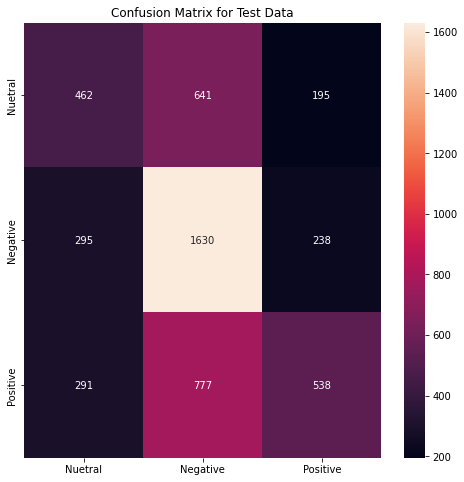




Test Accuracy: 51.90 %
Test Precision: 51.90 %
Test Recall: 51.90 %
Test F1-score: 51.90 %


In [ ]:
loss_fn = nn.CrossEntropyLoss()
True_label, Pred_label, _ = Evaluation_func(test_loader, GloVe_Classification_MLP_Model, loss_fn)

test_acc = accuracy_score(True_label, Pred_label)
test_prc = precision_score(True_label, Pred_label, average='micro')
test_rcl = recall_score(True_label, Pred_label, average='micro')
test_F1 = f1_score(True_label, Pred_label, average='micro')

test_cf = confusion_matrix(True_label, Pred_label)

classes=["Nuetral", "Negative", "Positive"]

plt.figure(figsize=(8, 8))
sns.heatmap(test_cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()
print("\n\n")
print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")
print(f"Test F1-score: {test_F1*100:.2f} %")

## Part 3: Pretrained BERT Model

In [ ]:
def utterances_dataset(data):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  utterances = []
  sentiments = []
  max_len = 0
  for i in range(len(data)):
    _, utt, sen = data[i]
    utterances.append(utt)
    sentiments.append(sen)
    if len(utt.split(" ")) > max_len:
      max_len = len(utt.split(" "))
      #print(max_len)
  utterances_tokenized = [tokenizer(utterance, padding='max_length', max_length=max_len,
                                    truncation=True, return_tensors="pt") for utterance in utterances]
  return tuple(zip(utterances_tokenized, sentiments))

In [ ]:
utterances_train_data = utterances_dataset(train_data)
utterances_test_data = utterances_dataset(test_data)
utterances_dev_data = utterances_dataset(dev_data)

In [ ]:
utterances_train_data[10]

({'input_ids': tensor([[  101,  1124,  1270,  1366,  1205,  1106,  1103,  1466,  1105,   176,
          26327,  1181,  1646,  1141,  1118,  1141,   119,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])},
 1)

In [ ]:
batch_size = 32
train_dataloader = DataLoader(utterances_train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(utterances_test_data, batch_size=batch_size, shuffle=False)
dev_dataloader = DataLoader(utterances_dev_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class BERT(nn.Module):

    def __init__(self):

        super().__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dense = nn.Linear(768, 3)

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x = self.dense(x)

        return F.softmax(x, dim=1)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_bert = BERT()
model_bert.to(device)
optimizer = torch.optim.Adam(model_bert.parameters(), lr = 5e-5)
loss_fn = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    running_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        input_id = X['input_ids'].squeeze(1).to(device)
        attention_mask = X['attention_mask'].to(device)
        y = y.to(device)

        pred = model(input_id, attention_mask)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 300 == 0:
            current = batch * len(y)
            print(f"loss: {running_loss/(batch+1):>7f}  [{current:>5d}/{size:>5d}]")

def val_loop(dataloader, model, loss_fn):

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  val_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      input_id = X['input_ids'].squeeze(1).to(device)
      attention_mask = X['attention_mask'].to(device)
      y = y.to(device)
      pred = model(input_id, attention_mask)
      val_loss += loss_fn(pred, y)
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
  print(f"Accuracy: {(100*correct):>0.1f}%, Average loss: {val_loss:>8f} \n")

  return val_loss

In [ ]:
epoch = 5
best_val_loss = np.Inf
patient = k = 2
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_bert.train()
    train_loop(train_dataloader, model_bert, loss_fn, optimizer)
    model_bert.eval()
    print("val Results:")
    val_loss = val_loop(dev_dataloader, model_bert, loss_fn)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model_bert, './best_model_bert.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_bert = torch.load('./best_model_bert.h5')
print(f'best val loss: {best_val_loss:.3f}')
     


Epoch: 1
----------------------------------------
loss: 1.169220  [    0/20240]
loss: 0.992353  [ 9600/20240]
loss: 0.967337  [19200/20240]
val Results:
Accuracy: 58.4%, Average loss: 0.951888 


Epoch: 2
----------------------------------------
loss: 0.871289  [    0/20240]
loss: 0.887846  [ 9600/20240]
loss: 0.891673  [19200/20240]
val Results:
Accuracy: 57.8%, Average loss: 0.957622 


Epoch: 3
----------------------------------------
loss: 0.942461  [    0/20240]
loss: 0.843473  [ 9600/20240]
loss: 0.851062  [19200/20240]
val Results:
Accuracy: 58.5%, Average loss: 0.955622 

Eearly stopping!
best val loss: 0.952


In [ ]:
Y = []
Pred = []
with torch.no_grad():
  for X, y in test_dataloader:
    input_id = X['input_ids'].squeeze(1).to(device)
    attention_mask = X['attention_mask'].to(device)
    y = y.cpu().data.numpy()
    pred = model_bert(input_id, attention_mask).argmax(dim=1).data.cpu().numpy()
    Y.extend(y)
    Pred.extend(pred)

In [ ]:
acc = accuracy_score(Y, Pred)
f1 = f1_score(Y, Pred, average='micro')
cf = confusion_matrix(Y, Pred)
print(f'accuracy on test data: {100*acc:.2f} %')
print(f'f1 score on test data: {100*f1:.2f} %')

accuracy on test data: 58.97 %
f1 score on test data: 58.97 %


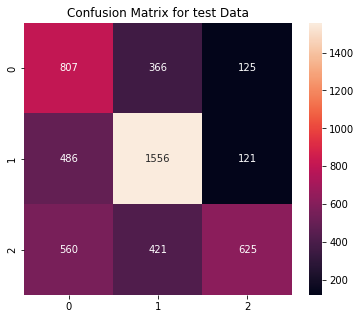

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for test Data')
plt.show()

## Evaluation and Results

The achieved scores for each part are listed in the following table:

|               | TF-IDF (CatBoost) | Word2Vec (CatBoost) | GloVe (MLP) | BERT    |
|---------------|-------------------|---------------------|-------------|---------|
| Test Accuracy | 48.45 %           | 43.67 %             | 51.90 %     | 58.97 % |
| Test F1 Score | 42.97 %           | 40.69 %             | 51.90 %     | 58.97 % |

As expected, the best accuracy belongs to the BERT model which has a sophisticated architecture compared to the other methods used in the previous parts.